# Setup

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from skimage import io
import glob, os, json, cv2, gc, shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

IMG_SIZE = 1024
INPUT_PATH = "../input/hubmap-kidney-segmentation"
MODEL_PATH = "../input/hubmap-model-v2/model.h5"
commit = False

def create_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
        
create_folder("./test")

# Image Functions

In [2]:
def read_tiff(image_path):
    image = io.imread(image_path)
    image = np.squeeze(image) # some images have unnecessary axes with shape 1 --> remove
    if image.shape[0] == 3: # some images have color as first axis -> swap axes
        image = image.swapaxes(0,1)
        image = image.swapaxes(1,2)
    return image
    
def slice_images(image_id, image, mask=[], folder=""):
    print('Slicing Image ' + image_id + ' ...')

    possible_slices_x = image.shape[0] // IMG_SIZE
    possible_slices_y = image.shape[1] // IMG_SIZE

    for x in range(possible_slices_x):
        for y in range(possible_slices_y):
            image_slice = image[x * IMG_SIZE : (x+1) * IMG_SIZE, y * IMG_SIZE : (y+1) * IMG_SIZE]
            
            if np.any(image_slice): # only process non-black --> no background images

                if not len(mask) == 0:
                    mask_slice = mask[x * IMG_SIZE : (x+1) * IMG_SIZE, y * IMG_SIZE : (y+1) * IMG_SIZE] * 255
                    if 255 in mask_slice:
                        cv2.imwrite(f"./{folder}/{image_id}-imgslice.{x}.{y}.jpg", image_slice)
                        cv2.imwrite(f"./{folder}/{image_id}-maskslice.{x}.{y}.png", mask_slice.astype(int))
                else:
                    cv2.imwrite(f"./{folder}/{image_id}-imgslice.{x}.{y}.jpg", image_slice)

## ref.: https://www.kaggle.com/bguberfain/memory-aware-rle-encoding
def rle_encode_less_memory(img):
    pixels = img.T.flatten()
    
    # This simplified method requires first and last pixel to be zero
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

def slice_test_images(test_image_shapes):
    df_train = pd.read_csv(os.path.join(INPUT_PATH, 'train.csv')) # use one train image as validation image (model was not trained with this)
    df_train = df_train.iloc[0:1, :]
    test_image_paths = sorted(glob.glob(os.path.join(INPUT_PATH, 'test/*.tiff')))
    
    for index, train_sample in df_train.iterrows():
        image_id = train_sample['id']
        encoded_mask = train_sample['encoding']

        image_path = os.path.join(INPUT_PATH, f"train/{image_id}.tiff")
        image = read_tiff(image_path)
        test_image_shapes.append((image_id, image.shape))
        
        create_folder(f"./test/{image_id}")
        slice_images(image_id, image, [], f"test/{image_id}")

# Image to Tensor Mapping

In [3]:
def image_to_tensor(image_path, is_png):
    image = tf.io.read_file(image_path)
    if is_png:
        image = tf.image.decode_png(image)
    else:
        image = tf.image.decode_jpeg(image)
        
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    return image


def prepare_images_for_unet(image_path, mask_path):
    image = image_to_tensor(image_path, is_png=False)
    mask = image_to_tensor(mask_path, is_png=True)

    return image, mask


def prepare_image_for_unet(image_path):
    image = image_to_tensor(image_path, is_png=False)

    return image

# Loss Functions & Metrics

In [4]:
# ref.: https://gist.github.com/CarloSegat/1a2816676c48607dac9dda38afe4f3d9
def weighted_binary_crossentropy(y_true, y_pred, weight1=5, weight0=1):
    y_true = K.clip(y_true, K.epsilon(), 1-K.epsilon())
    y_pred = K.clip(y_pred, K.epsilon(), 1-K.epsilon())
    logloss = -(y_true * K.log(y_pred) * weight1 + (1 - y_true) * K.log(1 - y_pred) * weight0 )
    return K.mean( logloss, axis=-1)

# ref.: https://github.com/keras-team/keras/issues/3611
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

# Slice Test Images

In [5]:
test_image_shapes = []
slice_test_images(test_image_shapes)

Slicing Image 2f6ecfcdf ...


# Predictions

In [6]:
model = keras.models.load_model(MODEL_PATH, custom_objects={'dice_coef':dice_coef, 'weighted_binary_crossentropy':weighted_binary_crossentropy})
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1024, 1024, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1024, 1024, 3 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 512, 512, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [7]:
#submission_path = './submission.csv'
#with open(submission_path, 'w') as f:
#    f.write("id,predicted\n")
df_submission = pd.read_csv("../input/hubmap-kidney-segmentation/test/sample_submission.csv")

# Image Functions

In [8]:
def plot_masked_image(image, mask, name):
    plt.imshow(image, interpolation='none')
    plt.imshow(mask, cmap='jet', alpha=0.3, interpolation='none')
    
    plt.savefig(f"./{name}.png", dpi = 1000)
    plt.show()
    
def read_tiff(image_path):
    image = io.imread(image_path)
    image = np.squeeze(image) # some images have unnecessary axes with shape 1 --> remove
    if image.shape[0] == 3: # some images have color as first axis -> swap axes
        image = image.swapaxes(0,1)
        image = image.swapaxes(1,2)
    return image

def read_mask(image, encoded_mask):
    mask = rle_decode(encoded_mask, (image.shape[1], image.shape[0])) # with inverted axes
    mask = mask.swapaxes(0,1) # swap back axes
    mask = np.expand_dims(mask, -1) # add one axis to have same shape as images
    return mask

# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# Predictions

In [9]:
def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)
    
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

../working/test/2f6ecfcdf/
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
          id predicted
0  2ec3f1bb9       NaN
1  3589adb90       NaN
2  d488c759a       NaN
3  aa05346ff       NaN
4  57512b7f1       NaN


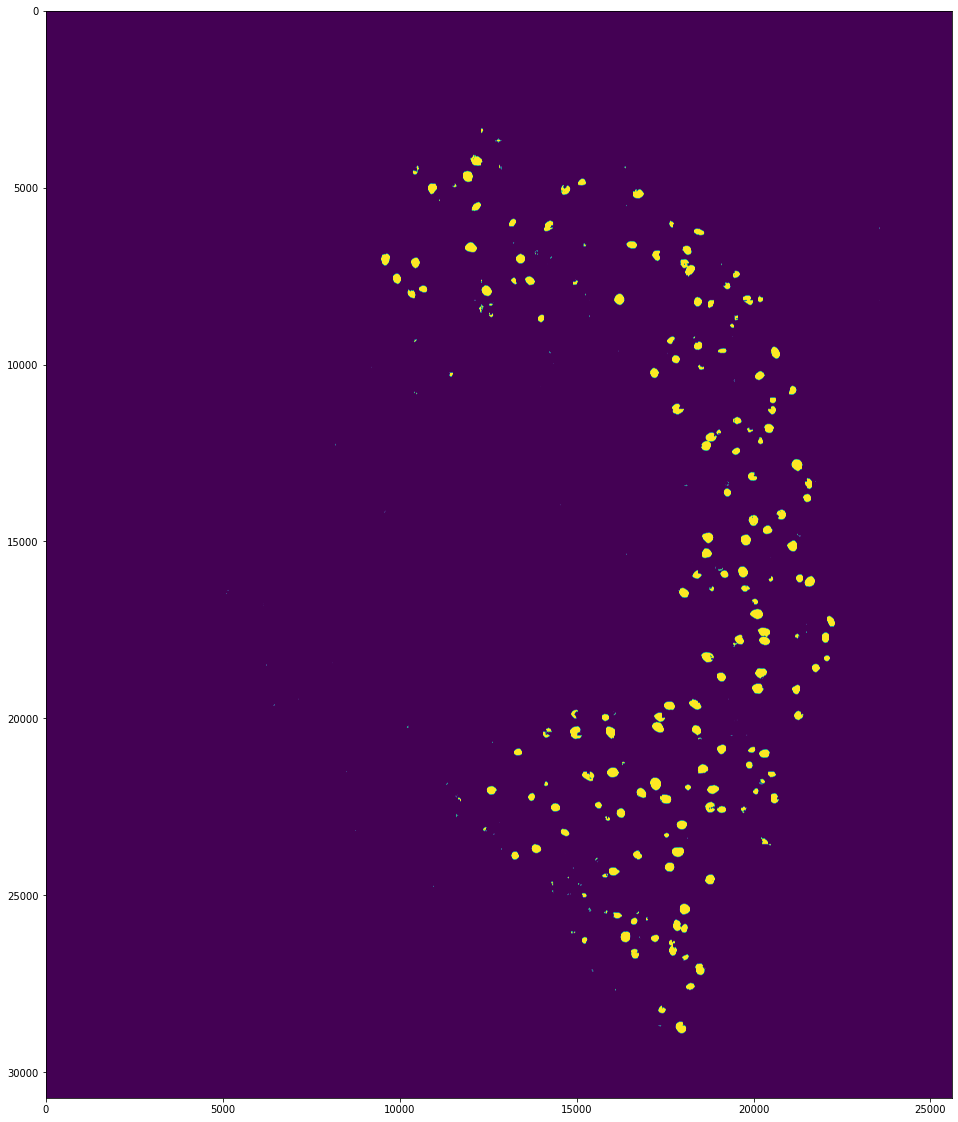

In [10]:
test_image_folders = sorted(glob.glob('../working/test/*/'))
df_train = pd.read_csv(os.path.join(INPUT_PATH, 'train.csv')) # use one train image as validation image (model was not trained with this)
for folder in test_image_folders:
    print(f"{folder}")
    image_id = folder.split('/')[-2]
    test_image_slice_paths = np.array(glob.glob(f"{folder}/*.jpg")).astype("str")
    
    original_shape = [item for item in test_image_shapes if item[0] == image_id][0][1]
    
    max_x = original_shape[0] // IMG_SIZE
    max_y = original_shape[1] // IMG_SIZE
    
    img = np.zeros((max_x*IMG_SIZE, max_y*IMG_SIZE, 1)).astype("uint8")
    
    for x in range(max_x):
        print(x)
        for y in range(max_y):
            img_path = f"{folder}{image_id}-imgslice.{x}.{y}.jpg"
            if img_path in test_image_slice_paths:
                image = prepare_image_for_unet(img_path)
                test_dataset = tf.data.Dataset.from_tensors((image)).batch(1)
                with tf.device('/GPU:0'):
                    mask = model.predict(test_dataset, verbose=0)[0]
                    mask = mask > 0.9
                    mask = mask.astype("uint8")
                    img[x*IMG_SIZE : (x+1)*IMG_SIZE, y*IMG_SIZE : (y+1)*IMG_SIZE] = mask
                    del mask
                del test_dataset
                del image
                gc.collect()

    df_submission.loc[df_submission.id == image_id, 'predicted'] = rle_encode_less_memory(img)
    
df_submission.to_csv('submission.csv', index=False)
print(df_submission)

#if commit:
plt.figure(figsize=(20,20))
plt.imshow(img);

# Cleanup

In [11]:
shutil.rmtree('./test')

# Plot Ground Truth Mask Over Test Image

In [12]:
image_path = os.path.join(INPUT_PATH, f"train/{image_id}.tiff")
image = read_tiff(image_path)
image_to_plot = cv2.resize(image, (0, 0), fx=0.25, fy=0.25)

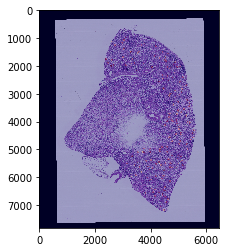

In [13]:
encoded_mask = df_train[df_train.id == image_id].iloc[0]['encoding']
true_mask = read_mask(image, encoded_mask)
true_mask_to_plot = cv2.resize((true_mask * 255).astype('float32'), (0, 0), fx=0.25, fy=0.25)

plot_masked_image(image_to_plot, true_mask_to_plot, image_id)
true_mask = np.squeeze(true_mask)
segmentation_mask = np.squeeze(img)
true_mask = true_mask[:segmentation_mask.shape[0], :segmentation_mask.shape[1]]

# Plot Predicted Mask Over Test Image

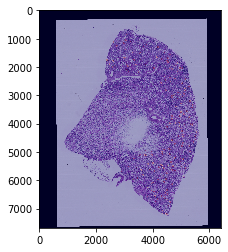

In [14]:
mask_to_plot = cv2.resize((img * 255).astype('float32'), (0, 0), fx=0.25, fy=0.25)

plot_masked_image(image_to_plot, mask_to_plot, image_id)

# Calculate Dice for Test Image

In [15]:
k=1
cur_dice_coef = dice(segmentation_mask, true_mask)
print(f"Dice: {cur_dice_coef}")

Dice: 0.9093134316474527
